# 1. Datensatz

## 1.1 Infos zum Datensatz

Ein erheblicher Teil des Gesamtenergieverbrauchs weltweit entfällt heutzutage auf Gebäude, insbesondere auf Heizung, Lüftung und Klimatechnik. Hier bieten sich durch intelligente Steuerung große Einsparpotenziale. Ein Baustein dafür sind Sensoren, die erkennen, ob sich Menschen in bestimmten Teilen des Gebäudes aufhalten und diese Information an die Gebäudesteuerung weiterleiten, sodass Energieverbraucher dynamisch zu- und abgeschaltet werden können. Der vorliegende Datensatz (Datensatz-Sensor.csv) enthält Messdaten, die von einem Sensor in einem Bürogebäude aufgezeichnet wurden. Eine Zeile beschreibt die Erfassung verschiedener Messwerte zu einem bestimmten Zeitpunkt an einem festen Ort (d.h., der Sensor wurde nicht bewegt). Leider kann der Sensor aktuell noch nicht messen, ob sich Personen im Raum befinden. Für den vorliegenden Zeitraum wurde die Anwesenheit einer Person aber manuell kontrolliert und den Messdaten hinzugefügt. Insgesamt existieren folgende Felder in den Daten:
- Datum: Zeitstempel im Format JJJJ-MM-DD hh:mm:ss
- Temperatur: Temperatur in Grad Celsius (°C)
- Luftfeuchtigkeit: relative Luftfeuchtigkeit in %
- CO2: CO2 Gehalt in ppm
- Wassergehalt: Verhältnis von Gewicht des verdunsteten Wassers zum Gewicht der trockenen Luft in kg Wasserdampf / kg Luft (abgeleitet aus Temperatur und Luftfeuchtigkeit)
- Anwesenheit: Ist eine Person anwesend (1) oder nicht (0).

# 2. Explorative Datenanalyse (EDA)

## 2.1 Überblick

Bevor wir mit der Bereinigung oder Modellierung beginnen, verschaffen wir uns einen Überblick über die Struktur der Rohdaten.
Ziel dieser ersten Inspektion ist es:
1.  Die **Dimensionen** des Datensatzes zu prüfen (Wie viele Zeilen/Spalten?).
2.  Die **Datentypen** zu validieren (Wird das Datum korrekt erkannt?).
3.  Erste **Auffälligkeiten** zu identifizieren (Gibt es fehlende Werte oder offensichtliche Ausreißer in der Statistik?).

Dafür brauchen wir folgende Imports:

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In diesem Schritt laden wir den Datensatz `Datensatz-Sensor.csv` und prüfen die Datenqualität.  
Wir untersuchen die Struktur mit `df.info()` und schauen uns statistische Kennzahlen mit `df.describe()` an, um erste Auffälligkeiten (z.B. fehlende Werte oder unrealistische Ausreißer) zu identifizieren.

In [2]:
df = pd.read_csv('data/Datensatz-Sensor.csv')

# Die ersten 5 Zeilen anzeigen (Wie sehen die Daten aus?)
display(df.head())

# Infos zu Datentypen und fehlenden Werten
print("--- Info zu Datentypen ---")
print(df.info())

# Statistische Übersicht
print("\n--- Statistische Beschreibung ---")
display(df.describe())

Datum  Temperatur  Feuchtigkeit         CO2  Wassergehalt  \
0  2015-02-02 14:19:00     23.7000        26.272  749.200000      0.004764   
1  2015-02-02 14:19:59     23.7180        26.290  760.400000      0.004773   
2  2015-02-02 14:21:00     23.7300        26.230  769.666667      0.004765   
3  2015-02-02 14:22:00     23.7225        26.125  774.750000      0.004744   
4  2015-02-02 14:23:00     23.7540        26.200  779.000000      0.004767   

   Anwesenheit  
0            1  
1            1  
2            1  
3            1  
4            1

--- Info zu Datentypen ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19236 entries, 0 to 19235
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datum         19236 non-null  object 
 1   Temperatur    19134 non-null  float64
 2   Feuchtigkeit  18915 non-null  float64
 3   CO2           19236 non-null  float64
 4   Wassergehalt  18777 non-null  float64
 5   Anwesenheit   19236 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 901.8+ KB
None

--- Statistische Beschreibung ---


Temperatur  Feuchtigkeit           CO2  Wassergehalt   Anwesenheit
count  19134.000000  18915.000000  19236.000000  18777.000000  19236.000000
mean      21.322743     27.451396    634.818354      0.004189      0.226606
std        3.908221      5.008853    260.246196      0.000759      0.418647
min       19.000000     16.745000      0.000000      0.002674      0.000000
25%       20.133333     24.290000    454.500000      0.003699      0.000000
50%       20.675000     27.171429    545.500000      0.004278      0.000000
75%       21.600000     31.050000    734.541667      0.004799      0.000000
max       55.998944     39.500000   2028.500000      0.006476      1.000000

## 2.2 Auffälligkeiten in den Daten:
Bei der Betrachtung der Statistik (`describe`) und Datentypen (`info`) fallen folgende Probleme auf, die im nächsten Schritt bereinigt werden müssen:

1.  **Falsches Datumsformat:** Die Spalte `Datum` wird aktuell als Text (`object`) erkannt und nicht als Zeitstempel. Zudem sind die Sekunden oft auf `:59`, was auf einen leichten Zeitversatz hindeutet.
2.  **Unrealistische Temperaturen:** Der Maximalwert liegt bei über 50°C. Da es sich um ein Büro handelt, ist dies ein offensichtlicher Messfehler (Ausreißer).
3.  **CO2-Ausfälle:** Der Minimalwert bei CO2 ist 0.0 ppm. Da die natürliche Außenluft bereits ca. 400 ppm CO2 enthält, deutet dies auf Sensorausfälle hin.

## 2.3 Visualisierung der Rohdaten
Um die Verteilung und mögliche Fehler besser zu erkennen, plotten wir die Zeitreihen für Temperatur und CO2.
Hierbei erwarten wir, die oben identifizierten Ausreißer (Temperatur > 50°C und CO2 = 0) grafisch bestätigen zu können.

In [3]:
# Damit Plotly die Zeitachse richtig malt, wandeln wir das Datum kurz um
df['Datum'] = pd.to_datetime(df['Datum'])

# Plot: Temperatur
fig_temp = px.scatter(df, x='Datum', y='Temperatur', title='Temperaturverlauf')
fig_temp.update_xaxes(tickmode = "linear")
fig_temp.show()

# Plot: CO2
fig_co2 = px.scatter(df, x='Datum', y='CO2', title='CO2-Verlauf')
fig_co2.update_xaxes(tickmode = "linear")
fig_co2.show()

# Ein Boxplot
fig_box_co2 = px.box(df, y='CO2', title='Statistische Verteilung & Ausreißer (co2)')
fig_box_co2.show()

fig_box_temp = px.box(df, y='Temperatur', title='Statistische Verteilung & Ausreißer (Temperatur)')
fig_box_temp.show()

# Plot: Anwesenheit am Wochentag
df["Anwesenheit_Prozent"] = df.groupby(df["Datum"].dt.date)["Anwesenheit"].transform(lambda x: x.sum() / x.count() * 100)

grouped_percentages = df.groupby(df["Datum"].dt.dayofweek).agg(Anwesenheit_Prozent=("Anwesenheit_Prozent", "first")).reset_index()

fig_anwesenheit = px.bar(
    grouped_percentages,
    x="Datum",
    y="Anwesenheit_Prozent",
    title="Prozentuale Anwesenheit pro Tag",
)
fig_anwesenheit.update_xaxes(tickmode="linear").show()
df.drop(columns=["Anwesenheit_Prozent"], inplace=True)

## 2.4 Analyse fehlender Werte
Datenlücken können durch Sensorausfälle oder Übertragungsfehler entstehen. Da wir nicht mit fehlenden Werte (`NaN`) arbeiten wollen, prüfen wir hier, welche Spalten betroffen sind.
Dies liefert uns die Begründung für die spätere **Interpolation** der Werte.

In [4]:
# Berechnen der fehlenden Werte pro Spalte
missing_count = df.isnull().sum()

# Wir filtern und zeigen nur Spalten an, die wirklich fehlende Werte haben
missing_data = missing_count[missing_count > 0]

print("Anzahl fehlender Werte pro Spalte:")
print(missing_data)

Anzahl fehlender Werte pro Spalte:
Temperatur      102
Feuchtigkeit    321
Wassergehalt    459
dtype: int64


## 2.5 Korrelationsanalyse
In diesem Schritt untersuchen wir die statistischen Zusammenhänge zwischen den verschiedenen Messwerten.

**Ziele:**
1.  **Relevanz prüfen:** Welche Sensoren korrelieren stark mit der Zielvariable `Anwesenheit`? Ein hoher Wert (nahe 1 oder -1) bedeutet, dass der Sensor ein guter Prädiktor ist.
2.  **Redundanz erkennen:** Korrelieren zwei Sensoren (z.B. Feuchtigkeit und Wassergehalt) extrem stark miteinander (> 0.9), enthalten sie fast die gleiche Information. Eine der beiden Spalten kann später entfernt werden, um das Modell nicht zu verwirren (Multikollinearität).

In [5]:
# Korrelationsmatrix berechnen
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Heatmap anzeigen
fig_corr = px.imshow(corr_matrix, text_auto='.2f', aspect="auto", color_continuous_scale='RdBu_r', title="Korrelationsmatrix")
fig_corr.show()

# Anwesenheit vs. CO2
# Da Anwesenheit (0/1) kategorisch ist, eignet sich ein Boxplot besser als ein Scatterplot
df['Status'] = df['Anwesenheit'].map({0: 'Leer', 1: 'Besetzt'})

fig_box = px.box(df, x='Status', y='CO2', color='Status',title='Einfluss von Anwesenheit auf den CO2-Gehalt', color_discrete_map={'Leer': 'blue', 'Besetzt': 'red'})
fig_box.show()

# Aufräumen
df = df.drop(columns=['Status'])

# 3. Datenvorverarbeitung und Feature Engineering

## 3.1 Datenvorverarbeitung
Im ersten Schritt korrigieren wir technische Unsauberkeiten in den Rohdaten.
* **Zeit-Korrektur:** Sekunden werden auf die nächste volle Minute gerundet (z.B. `xx:xx:59` $\rightarrow$ `xx:(xx+1):00`), um saubere Zeitstempel zu erhalten.
* **Ausreißer entfernen:** Wir setzen physikalisch unmögliche Werte (Temperatur > 40°C, CO2 < 50 ppm) auf `NaN`.
* **Interpolation:** Die entstandenen Lücken füllen wir linear auf, um den Zeitreihen-Charakter zu erhalten.

In [6]:
# Wir arbeiten absofort auf einer Kopie weiter
df_clean = df.copy()

### Zeit-Korrektur

In [7]:
# Datum korrigieren
def datumkorriegieren(df_input):
    df = df_input.copy()
    if df['Datum'].dtype == 'object':
        df['Datum'] = pd.to_datetime(df['Datum'])

    # Runden: Wenn Sekunde == 59, addiere 1 Sekunde
    mask_59 = df['Datum'].dt.second == 59
    if mask_59.sum() > 0:
        df.loc[mask_59, 'Datum'] += pd.Timedelta(seconds=1)

    return df


### Ausreißer entfernen und Interpolation

In [8]:
def bereinige_daten(df_input):
    df = df_input.copy()

    # Ausreißer weg
    df.loc[df['Temperatur'] > 40, 'Temperatur'] = np.nan
    df.loc[df['CO2'] < 50, 'CO2'] = np.nan

    # Lücken füllen
    df = df.interpolate(method='linear', limit_direction='both')
    
    return df

### Anwendung der Funktionen

In [9]:
from sklearn.model_selection import train_test_split
# Datum
df_clean = datumkorriegieren(df_clean) 
df_clean = df_clean.sort_values('Datum') # Wichtig für Zeitreihe

# 3. Splitten (Training & Test)
X = df_clean.drop(columns=['Anwesenheit'])
y = df_clean['Anwesenheit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4. Feinreinigung anwenden (Getrennt!)
X_train_clean = bereinige_daten(X_train)
X_test_clean = bereinige_daten(X_test)

### Visualisierung der neuen Daten

In [10]:
# Plot: Temperatur
fig_temp = px.scatter(X_train_clean, x='Datum', y='Temperatur', title='Temperaturverlauf')
fig_temp.update_xaxes(tickmode = "linear")
fig_temp.show()

# Plot: CO2
fig_co2 = px.scatter(X_train_clean, x='Datum', y='CO2', title='CO2-Verlauf')
fig_co2.update_xaxes(tickmode = "linear")
fig_co2.show()

# Optional: Ein Boxplot zeigt Ausreißer noch brutaler
fig_box_co2 = px.box(X_train_clean, y='CO2', title='Statistische Verteilung & Ausreißer (co2)')
fig_box_co2.show()

fig_box_temp = px.box(X_train_clean, y='Temperatur', title='Statistische Verteilung & Ausreißer (Temperatur)')
fig_box_temp.show()

## 3.2 Feature Engineering  
Zeit ist für ein Modell schwer zu verstehen. 23:00 Uhr und 00:00 Uhr liegen zahlenmäßig weit auseinander, in der Realität aber direkt nebeneinander.
* **Zyklische Transformation:** Wir berechnen die "Minute des Tages" und transformieren diese mit Sinus und Cosinus. So liegen Abend und Morgen im Vektorraum nah beieinander.
* **Logische Features:** Wir definieren `Ist_Buerozeit` (Mo-Fr, 07:00–18:00 Uhr), da hier die Wahrscheinlichkeit für Anwesenheit am höchsten ist. Außerdem schauen wir, ob es sich um einen Feiertag handelt und definierten `Tagesart_Werktag`

In [11]:
import holidays

# Diese Funktion lernt die Arbeitszeiten NUR aus dem Trainingssatz
def lerne_kernarbeitszeiten(X_train, y_train):
    # Wir fügen kurz X und y zusammen, nur um die Zeiten zu finden
    df_temp = X_train.copy()
    df_temp['Anwesenheit'] = y_train
    
    anwesenheits_zeiten = df_temp[df_temp['Anwesenheit'] == 1]
    
    # Min/Max Stunde pro Wochentag ermitteln
    stats = anwesenheits_zeiten['Datum'].dt.hour.groupby(anwesenheits_zeiten['Datum'].dt.dayofweek).agg(['min', 'max'])
    
    return stats

# Das ist deine Haupt-Funktion für Features
def erstelle_features(df_input, arbeitszeiten_stats=None):
    df = df_input.copy()
    
    # 1. Basis-Zeit-Features
    stunde = df['Datum'].dt.hour
    minute = df['Datum'].dt.minute
    wochentag = df['Datum'].dt.dayofweek
    df['Jahr'] = df['Datum'].dt.year
    df['Wochentag'] = wochentag

    # 2. Zyklische Zeit 
    minute_of_day = stunde * 60 + minute
    df['time_sin'] = np.sin(2 * np.pi * minute_of_day / 1440)
    df['time_cos'] = np.cos(2 * np.pi * minute_of_day / 1440)

    # 3. CO2 Delta
    # Hinweis: Die ersten 15 Zeilen sind NaN, wir füllen mit 0
    df['CO2_Delta_15min'] = df['CO2'].diff(periods=15).fillna(0)

    # 4. Feiertage (Holidays)
    # Wir holen uns die Jahre aus dem Datensatz
    years = df['Jahr'].unique()
    de_holidays = holidays.DE(years=years) 
    
    def ist_werktag(datum):
        if datum in de_holidays: return 0 # Feiertag -> Kein Werktag
        if datum.dayofweek >= 5: return 0 # Wochenende -> Kein Werktag
        return 1
    
    df['Tagesart_Werktag'] = df['Datum'].apply(ist_werktag)

    # 5. Dynamische Bürozeit (Das Problemkind)
    # Wenn wir keine Stats haben (z.B. weil wir noch nicht trainiert haben),
    # können wir das Feature nicht bauen oder füllen es mit 0.
    if arbeitszeiten_stats is not None:
        def check_kernzeit(row):
            wd = row['Datum'].dayofweek
            hr = row['Datum'].hour
            
            # Wenn für diesen Tag keine Regeln existieren (z.B. Sonntag war nie jemand da)
            if wd not in arbeitszeiten_stats.index:
                return 0
            
            start = arbeitszeiten_stats.loc[wd, 'min']
            ende = arbeitszeiten_stats.loc[wd, 'max']
            
            # Puffer +/- 1 Stunde
            if (hr >= start - 1) and (hr <= ende + 1):
                return 1
            return 0
        
        df['Ist_Buerozeit_Dyn'] = df.apply(check_kernzeit, axis=1)
    else:
        # Fallback, falls keine Stats übergeben wurden
        df['Ist_Buerozeit_Dyn'] = 0

    return df


In [12]:
# ---------------------------------------------------------
# ABLAUF NACH DEM SPLIT (Wir haben schon X_train_clean, X_test_clean)
# ---------------------------------------------------------

# 1. Wir lernen die Arbeitszeiten NUR vom Training (Spicken erlaubt!)
stats_vom_training = lerne_kernarbeitszeiten(X_train_clean, y_train)

print("Gelernte Arbeitszeiten (nur aus Training):")
print(stats_vom_training)

# 2. Features für Training erstellen
X_train_final = erstelle_features(X_train_clean, arbeitszeiten_stats=stats_vom_training)

# 3. Features für Test erstellen 
# WICHTIG: Wir nutzen die Stats vom Training! Wir gucken NICHT in y_test!
X_test_final = erstelle_features(X_test_clean, arbeitszeiten_stats=stats_vom_training)

# 4. Aufräumen: Spalten, die das Modell nicht braucht, droppen
# 'Datum' und 'Jahr' brauchen wir meist nicht mehr, da wir features haben
cols_to_drop = ['Datum', 'Jahr'] 
X_train_final = X_train_final.drop(columns=cols_to_drop)
X_test_final = X_test_final.drop(columns=cols_to_drop)

print("\nFertige Spalten für das Modell:")
print(X_train_final.columns.tolist())

Gelernte Arbeitszeiten (nur aus Training):
       min  max
Datum          
0        8   18
1        7   18
2        7   18
3        7   18
4        7   18

Fertige Spalten für das Modell:
['Temperatur', 'Feuchtigkeit', 'CO2', 'Wassergehalt', 'Wochentag', 'time_sin', 'time_cos', 'CO2_Delta_15min', 'Tagesart_Werktag', 'Ist_Buerozeit_Dyn']


In [13]:
df_plot = X_train_final.copy()
df_plot['Datum'] = X_train['Datum'] # Datum wiederholen

# Dein Plot-Code (angepasst auf Training + Fehler entfernt)
fig_werktag = px.histogram(df_plot, x="Datum", color="Tagesart_Werktag").update_xaxes(tickangle=-45, tickmode="linear")
fig_werktag.show()

# 4. Modelle Modellierung und Evaluation

## 4.1 Vorbereitung: Split und Skalierung
Wir verwenden nun den bereinigten Datensatz `df_final`.
1.  **Vorbereitung:** Wir trennen die Zielvariable (`Anwesenheit`) von den Features (X).
2.  **Train-Test-Split:** Aufteilung in 80% Training und 20% Test.
3.  **Skalierung:** Standardisierung der Werte für die Logistische Regression.

In [14]:
# 1. Imports laden (Das brauchen wir alles)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report

# 2. Split überspringen wir! (Haben wir ja schon)
# Wir nutzen direkt: X_train_final, y_train, X_test_final, y_test

# 3. Skalierung (Wichtig für Logistische Regression!)
scaler = StandardScaler()

# ACHTUNG: Der Scaler macht aus der Tabelle ein "dummes" Zahlen-Array ohne Namen.
# Wir tricksen kurz, damit wir die Spaltennamen behalten (wichtig für späteres Auswerten)
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_final), 
    columns=X_train_final.columns,
    index=X_train_final.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_final), 
    columns=X_test_final.columns,
    index=X_test_final.index
)

# Cross-Validation Strategie für Zeitreihen festlegen
tscv = TimeSeriesSplit(n_splits=5)

results_list = []
print("Daten erfolgreich skaliert!")
print(f"Trainingsdaten Form: {X_train_scaled.shape}")

Daten erfolgreich skaliert!
Trainingsdaten Form: (15388, 10)


## 4.2 Modell 1: Logistische Regression
Wir starten mit der Logistischen Regression als Basis. Sie trennt die Klassen linear.

In [15]:
# Modell initialisieren & trainieren
model_lr = LogisticRegressionCV(cv=tscv, scoring="roc_auc", class_weight="balanced", random_state=42)
model_lr.fit(X_train_scaled, y_train)

# Vorhersage
y_pred_lr = model_lr.predict(X_test_scaled)

# Auswertung speichern
report_lr = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)

results_list.append({
    "Modell": "Logistische Regression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision (1)": report_lr.get('1', {}).get('precision', 0.0),
    "Recall (1)": report_lr.get('1', {}).get('recall', 0.0),
    "F1-Score (1)": report_lr.get('1', {}).get('f1-score', 0.0)
})

print("Logistische Regression abgeschlossen.")

Logistische Regression abgeschlossen.


## 4.4 Modell 2: Random Forest
Der Random Forest kombiniert viele Entscheidungsbäume ("Ensemble"). Er ist meist robuster und genauer als einzelne Bäume.

In [16]:
# 1. Modell initialisieren
# random_state=42 sorgt dafür, dass immer das gleiche rauskommt (wichtig für die Abgabe!)
model_rf = RandomForestClassifier(random_state=42)

# 2. Trainieren
# WICHTIG: Hier 'X_train_scaled' nutzen, sonst fehlen deine neuen Features!
model_rf.fit(X_train_scaled, y_train)

# 3. Vorhersage (auch auf den skalierten Testdaten)
y_pred_rf = model_rf.predict(X_test_scaled)

# 4. Auswertung speichern
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Das append war schon perfekt
results_list.append({
    "Modell": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision (1)": report_rf['1']['precision'],
    "Recall (1)": report_rf['1']['recall'],
    "F1-Score (1)": report_rf['1']['f1-score']
})

print("Random Forest abgeschlossen.")
importance = pd.Series(model_rf.feature_importances_, index=X_train_scaled.columns)
print(importance.sort_values(ascending=False))

Random Forest abgeschlossen.
CO2                  0.232617
time_cos             0.173175
Temperatur           0.163399
Ist_Buerozeit_Dyn    0.140253
CO2_Delta_15min      0.116409
time_sin             0.062796
Wassergehalt         0.040967
Feuchtigkeit         0.038325
Wochentag            0.026672
Tagesart_Werktag     0.005387
dtype: float64


## 4.5 Modell 3: Gradient Boosing

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import plotly.express as px

# Modell initialisieren
gb_model = GradientBoostingClassifier(random_state=42)

print("Trainiere Gradient Boosting...")
# 1. ÄNDERUNG: Scaled Daten nehmen!
gb_model.fit(X_train_scaled, y_train)

# Vorhersage
# 2. ÄNDERUNG: Scaled Daten nehmen!
y_pred_gb = gb_model.predict(X_test_scaled)

# Auswertung
report_gb = classification_report(y_test, y_pred_gb, output_dict=True)
results_list.append({
    "Modell": "Gradient Boosting",
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision (1)": report_gb['1']['precision'],
    "Recall (1)": report_gb['1']['recall'],
    "F1-Score (1)": report_gb['1']['f1-score']
})


print("Gradient Boosting abgeschlossen.")

# Feature Importance
importances_gb = gb_model.feature_importances_

# 3. ÄNDERUNG: Spaltennamen von den trainierten Daten nehmen (nicht vom originalen X!)
df_imp_gb = pd.DataFrame({
    'Feature': X_train_scaled.columns, 
    'Importance': importances_gb
}).sort_values('Importance', ascending=True) # Sortieren, damit der Plot schön aussieht

fig_gb = px.bar(df_imp_gb, x='Importance', y='Feature', orientation='h', title='Wichtigste Features (Gradient Boosting)')
fig_gb.update_layout(template="plotly_white", height=600)
fig_gb.show()

Trainiere Gradient Boosting...
Gradient Boosting abgeschlossen.


## 4.5 Modell 4 (Optional): Entscheidungsbaum (Decision Tree)
Der Decision Tree lernt komplexe, nicht-lineare Regeln. Er ist gut interpretierbar, neigt aber ohne Begrenzung zum Overfitting.

In [18]:
# Modell initialisieren
# random_state=42 für Vergleichbarkeit
model_dt = DecisionTreeClassifier(random_state=42) 

# Trainieren mit den fertigen Features!
model_dt.fit(X_train_scaled, y_train)

# Vorhersage
y_pred_dt = model_dt.predict(X_test_scaled)

# Auswertung speichern
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
results_list.append({
    "Modell": "Entscheidungsbaum",
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision (1)": report_dt['1']['precision'],
    "Recall (1)": report_dt['1']['recall'],
    "F1-Score (1)": report_dt['1']['f1-score']
})

print("Entscheidungsbaum abgeschlossen.")

Entscheidungsbaum abgeschlossen.


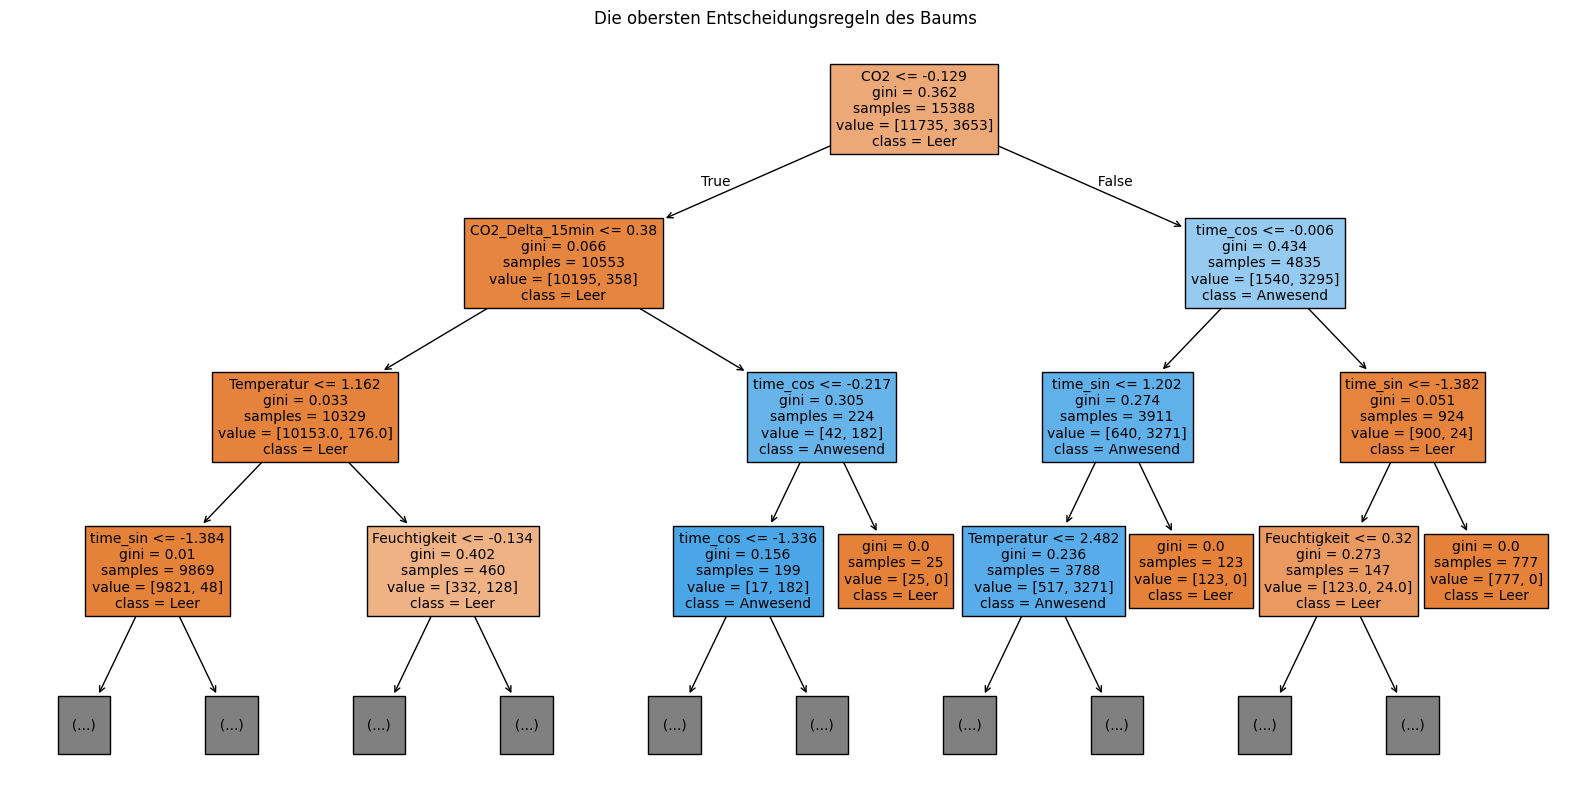

In [19]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    model_dt, 
    feature_names=X_train_scaled.columns, 
    class_names=['Leer', 'Anwesend'],
    filled=True, 
    max_depth=3, # Wir zeigen nur die oberen 3 Ebenen, sonst wird es riesig
    fontsize=10
)
plt.title("Die obersten Entscheidungsregeln des Baums")
plt.show()

## 4.5 Ergebnisvergleich
Wir fassen die Metriken aller drei Modelle zusammen. Besonderes schauen wir auf den **F1-Score der Klasse 1 (Anwesend)**, da dieser Precision und Recall vereint und uns zeigt, wie gut das Modell Personen erkennt.

In [20]:
# DataFrame erstellen
results_df = pd.DataFrame(results_list)
results_df = results_df.round(4)

# Anzeigen
print("Vergleich der Modelle:")
display(results_df)

Vergleich der Modelle:


Modell  Accuracy  Precision (1)  Recall (1)  F1-Score (1)
0  Logistische Regression    0.8986         0.6442      1.0000        0.7836
1           Random Forest    0.9919         0.9617      0.9958        0.9784
2       Gradient Boosting    0.8953         0.6374      0.9958        0.7772
3       Entscheidungsbaum    0.8225         0.5088      0.9462        0.6617

# 5. Modell-Optimierung (Hyperparameter Tuning)

## 5.1 GridSearch
Obwohl der Random Forest bereits sehr gute Ergebnisse liefert (siehe Vergleichstabelle), nutzen wir **GridSearch mit 5-facher Kreuzvalidierung**, um die optimalen Einstellungen zu finden und sicherzugehen, dass das Ergebnis kein Zufall war.
Wir testen verschiedene Kombinationen aus:
* `n_estimators`: Anzahl der Bäume (50, 100, 200)
* `max_depth`: Maximale Tiefe der Bäume (begrenzt vs. unbegrenzt)

In [21]:
from sklearn.model_selection import GridSearchCV

# 1. Wir definieren das Gitter (die Kandidaten)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
}

# 2. GridSearch initialisieren
# cv=tscv nimmt deine Zeitreihen-Strategie von vorhin
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), # WICHTIG: random_state für Reproduzierbarkeit
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1, # Alle Kerne nutzen (macht es schneller)
    verbose=1
)

print("Starte Optimierung...")
# WICHTIG: Hier X_train_scaled nutzen (da sind deine Features drin!)
grid_search.fit(X_train_scaled, y_train)

# Das beste Modell speichern
best_rf_model = grid_search.best_estimator_

print(f"\nBeste Parameter: {grid_search.best_params_}")
print(f"Beste Accuracy (Cross-Validation): {grid_search.best_score_:.4f}")

from sklearn.metrics import classification_report, accuracy_score

# Vorhersage mit dem GEWINNER-Modell auf den TEST-Daten
# WICHTIG: Auch hier X_test_scaled nutzen!
y_pred_optimiert = best_rf_model.predict(X_test_scaled)

# Jetzt vergleichen wir fair:
print("--- Ergebnis des optimierten Modells auf Testdaten ---")
print(f"Echte Accuracy: {accuracy_score(y_test, y_pred_optimiert):.4f}")
print(classification_report(y_test, y_pred_optimiert))

Starte Optimierung...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

Beste Parameter: {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 200}
Beste Accuracy (Cross-Validation): 0.9280
--- Ergebnis des optimierten Modells auf Testdaten ---
Echte Accuracy: 0.9771
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3142
           1       0.89      1.00      0.94       706

    accuracy                           0.98      3848
   macro avg       0.94      0.99      0.96      3848
weighted avg       0.98      0.98      0.98      3848



## 5.2 Feature Importance
Ein großer Vorteil von Entscheidungsbäumen ist ihre Interpretierbarkeit. Wir extrahieren die **Feature Importance**, um zu verstehen, welche Sensoren für die Vorhersage der Anwesenheit am wichtigsten sind.
* **Erwartung:** CO2 und die zeitliche Veränderung (Delta) sollten einen großen Einfluss haben.

In [22]:
# Daten für den Plot holen
importances = best_rf_model.feature_importances_

# KORREKTUR: Wir nehmen die Spaltennamen von den Trainingsdaten!
feature_names = X_train_scaled.columns 

# DataFrame erstellen
df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plotten
fig_imp = px.bar(df_imp, 
                 x='Importance', 
                 y='Feature', 
                 orientation='h', 
                 title='Einflussfaktoren: Worauf achtet die KI?',
                 text_auto='.3f',
                 color='Importance',
                 color_continuous_scale='Viridis')

fig_imp.update_layout(showlegend=False, template="plotly_white")
fig_imp.show()

## 5.3 Fehleranalyse (Confusion Matrix)
Abschließend prüfen wir mit der Confusion Matrix, wo genau das optimierte Modell noch Fehler macht.

In [23]:
from sklearn.metrics import confusion_matrix
import plotly.express as px

# 1. Vorhersagen machen (WICHTIG: Immer X_test_scaled nehmen!)
y_pred_opt = best_rf_model.predict(X_test_scaled)  # Random Forest
y_pred_gb = gb_model.predict(X_test_scaled)        # Gradient Boosting
y_pred_lg = model_lr.predict(X_test_scaled)        # Logistic Regression

# 2. Matrizen berechnen
cm_rf = confusion_matrix(y_test, y_pred_opt)
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_lg = confusion_matrix(y_test, y_pred_lg)

# 3. Plotten (Random Forest)
fig_cm = px.imshow(cm_rf,
                   text_auto=True,
                   x=['Leer (0)', 'Besetzt (1)'],
                   y=['Leer (0)', 'Besetzt (1)'],
                   color_continuous_scale='Blues',
                   title="Confusion Matrix (Optimierter Random Forest)")
fig_cm.update_layout(xaxis_title="Vorhersage", yaxis_title="Wahrheit")
fig_cm.show()

# 4. Plotten (Gradient Boosting)
fig_cm2 = px.imshow(cm_gb,
                    text_auto=True,
                    x=['Leer (0)', 'Besetzt (1)'],
                    y=['Leer (0)', 'Besetzt (1)'],
                    color_continuous_scale='Blues',
                    title="Confusion Matrix (Gradient Boosting)")
fig_cm2.update_layout(xaxis_title="Vorhersage", yaxis_title="Wahrheit")
fig_cm2.show()

# 5. Plotten (Logistische Regression)
fig_cm3 = px.imshow(cm_lg,
                    text_auto=True,
                    x=['Leer (0)', 'Besetzt (1)'],
                    y=['Leer (0)', 'Besetzt (1)'],
                    color_continuous_scale='Blues',
                    title="Confusion Matrix (Logistische Regression)")
fig_cm3.update_layout(xaxis_title="Vorhersage", yaxis_title="Wahrheit")
fig_cm3.show()

## 5.4 ROC-Kurve

In [24]:
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

# 1. Wahrscheinlichkeiten holen
# WICHTIG: Überall X_test_scaled nutzen, damit die Features (Sinus, Bürozeit) da sind!
y_probs_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]
y_probs_gb = gb_model.predict_proba(X_test_scaled)[:, 1]
y_probs_lg = model_lr.predict_proba(X_test_scaled)[:, 1]

# 2. ROC Daten berechnen (Bleibt gleich)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_probs_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_lg, tpr_lg, _ = roc_curve(y_test, y_probs_lg)
roc_auc_lg = auc(fpr_lg, tpr_lg)

# 3. Plotten
fig_roc = go.Figure()
fig_roc.add_trace(go.Scatter(x=fpr_rf, y=tpr_rf, name=f'Random Forest (AUC = {roc_auc_rf:.3f})'))
fig_roc.add_trace(go.Scatter(x=fpr_gb, y=tpr_gb, name=f'Gradient Boosting (AUC = {roc_auc_gb:.3f})'))
fig_roc.add_trace(go.Scatter(x=fpr_lg, y=tpr_lg, name=f'Logistische Regression (AUC = {roc_auc_lg:.3f})'))

# Diagonale (Zufallslinie)
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash', color='grey'), name='Zufall (Raten)'))

fig_roc.update_layout(
    title='ROC Kurve Vergleich: Welches Modell ist am besten?',
    xaxis_title='False Positive Rate (Fehlalarm-Quote)', 
    yaxis_title='True Positive Rate (Treffer-Quote)',
    template="plotly_white", # Macht es wieder schön sauber
    width=800,
    height=600
)
fig_roc.show()

In [25]:
# 1. Wir laden das Original nochmal "frisch", damit es wirklich roh ist
# (also mit String-Datum, potenziellen Ausreißern etc.)
df_raw = pd.read_csv('Data/Datensatz-Sensor.csv')

# 2. Wir nehmen 20 zufällige Zeilen als "Stichprobe"
# random_state sorgt dafür, dass wir immer dieselben 20 kriegen
df_simulation = df_raw.sample(20, random_state=999)

# 3. Wir speichern das als neue Datei ab (ohne Index-Nummer, damit es echt aussieht)
df_simulation.to_csv('testdaten_simulation.csv', index=False)

print("Simulations-Datei erstellt: 'testdaten_simulation.csv'")
print("Du kannst jetzt testen, ob dein Code diese Datei schluckt!")

Simulations-Datei erstellt: 'testdaten_simulation.csv'
Du kannst jetzt testen, ob dein Code diese Datei schluckt!


In [29]:
# ==============================================================================
# FINALER TEST: ALLE MODELLE IM VERGLEICH (SIMULATION ODER ECHT)
# ==============================================================================

# 1. Dateinamen anpassen (Simulation oder echt)
dateiname_prof = 'testdaten_simulation.csv' 

try:
    print(f"--- Lade Datei: {dateiname_prof} ---")
    df_prof = pd.read_csv(dateiname_prof)

    # ---------------------------------------------------------
    # A) PIPELINE: Daten putzen (Exakt wie im Training)
    # ---------------------------------------------------------
    
    # Datum korrigieren
    if df_prof['Datum'].dtype == 'object':
        df_prof['Datum'] = pd.to_datetime(df_prof['Datum'])
    
    mask_59 = df_prof['Datum'].dt.second == 59
    if mask_59.sum() > 0:
        df_prof.loc[mask_59, 'Datum'] += pd.Timedelta(seconds=1)

    # Ausreißer & Lücken
    df_prof.loc[df_prof['Temperatur'] > 40, 'Temperatur'] = np.nan
    df_prof.loc[df_prof['CO2'] < 50, 'CO2'] = np.nan
    df_prof = df_prof.interpolate(method='linear', limit_direction='both')

    # Features erstellen (WICHTIG: Mit Training-Stats!)
    df_prof_final = erstelle_features(df_prof, arbeitszeiten_stats=stats_vom_training)

    # Lösung trennen (falls vorhanden)
    y_prof_echt = None
    if 'Anwesenheit' in df_prof_final.columns:
        y_prof_echt = df_prof_final['Anwesenheit']
        X_prof = df_prof_final.drop(columns=['Anwesenheit'])
    else:
        X_prof = df_prof_final.copy()

    # Unnötige Spalten weg
    cols_to_drop = ['Datum', 'Jahr']
    X_prof = X_prof.drop(columns=[c for c in cols_to_drop if c in X_prof.columns])

    # Skalieren (Mit Scaler vom Training!)
    X_prof_scaled = pd.DataFrame(scaler.transform(X_prof), columns=X_prof.columns)
    
    print("Daten erfolgreich vorbereitet.\n")

    # ---------------------------------------------------------
    # B) VORHERSAGE: Alle Modelle müssen ran
    # ---------------------------------------------------------
    
    # Wir packen alle deine Modelle in eine Liste (Dictionary)
    meine_modelle = {
        #"Decision Tree": model_dt,
        "Logistische Reg.": model_lr,
        "Random Forest (Opt)": best_rf_model,
        "Gradient Boosting": gb_model
    }
    
    # Wir speichern die Ergebnisse in einer Tabelle
    df_ergebnisse = df_prof[['Datum']].copy()
    
    # Wenn wir die echte Lösung haben, speichern wir sie auch
    if y_prof_echt is not None:
        df_ergebnisse['ECHT'] = y_prof_echt

    print("--- Start der Vorhersagen ---")
    
    for modell_name, modell_objekt in meine_modelle.items():
        # Vorhersage machen
        pred = modell_objekt.predict(X_prof_scaled)
        
        # In Tabelle speichern
        df_ergebnisse[modell_name] = pred
        
        # Falls Lösung vorhanden: Direkt Genauigkeit berechnen
        if y_prof_echt is not None:
            acc = accuracy_score(y_prof_echt, pred)
            print(f"Genauigkeit {modell_name}: {acc:.2%}")

    # ---------------------------------------------------------
    # C) ERGEBNIS ANZEIGEN
    # ---------------------------------------------------------
    print("\n--- Auszug aus den Vorhersagen ---")
    display(df_ergebnisse.head(20))
    
    # Optional: Als CSV speichern für den Prof
    df_ergebnisse.to_csv('meine_vorhersagen.csv', index=False)
    print("\nAlle Vorhersagen wurden in 'meine_vorhersagen.csv' gespeichert.")

except FileNotFoundError:
    print(f"Fehler: Datei '{dateiname_prof}' nicht gefunden.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")

--- Lade Datei: testdaten_simulation.csv ---
Daten erfolgreich vorbereitet.

--- Start der Vorhersagen ---
Genauigkeit Logistische Reg.: 85.00%
Genauigkeit Random Forest (Opt): 95.00%
Genauigkeit Gradient Boosting: 100.00%

--- Auszug aus den Vorhersagen ---


Datum  ECHT  Logistische Reg.  Random Forest (Opt)  \
0  2015-02-09 22:59:00     0                 0                    0   
1  2015-02-05 22:59:00     0                 0                    0   
2  2015-02-13 17:32:00     1                 1                    1   
3  2015-02-08 08:44:00     0                 0                    0   
4  2015-02-14 16:40:00     0                 0                    0   
5  2015-02-13 10:46:00     1                 1                    1   
6  2015-02-12 00:45:00     0                 0                    0   
7  2015-02-09 19:25:00     0                 1                    0   
8  2015-02-16 13:52:00     1                 1                    1   
9  2015-02-05 13:04:00     0                 1                    1   
10 2015-02-17 08:45:00     1                 1                    1   
11 2015-02-05 19:01:00     0                 0                    0   
12 2015-02-15 03:42:00     0                 0                    0   
13 2015-02-12 00:04:00     0                 0                    0   
14 2015-02-04 20:38:00     0                 0                    0   
15 2015-02-14 05:34:00     0                 0                    0   
16 2015-02-03 00:56:00     0                 0                    0   
17 2015-02-03 03:06:00     0                 0                    0   
18 2015-02-05 18:16:00     0                 1                    0   
19 2015-02-15 04:31:00     0                 0                    0   

    Gradient Boosting  
0                   0  
1                   0  
2                   1  
3                   0  
4                   0  
5                   1  
6                   0  
7                   0  
8                   1  
9                   0  
10                  1  
11                  0  
12                  0  
13                  0  
14                  0  
15                  0  
16                  0  
17                  0  
18                  0  
19                  0


Alle Vorhersagen wurden in 'meine_vorhersagen.csv' gespeichert.
